# Linear Regression Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

In [2]:
# Read in the data
df = pd.read_csv('standard_atmosphere.txt')
df.head(100)

,Altitude,Temperature,Gravity,Pressure,Density,Viscosity
0,-1000,21.50,9.810,11.390000,1.347000,1.821
1,0,15.00,9.807,10.130000,1.225000,1.789
2,1000,8.50,9.804,8.988000,1.112000,1.758
3,2000,2.00,9.801,7.950000,1.007000,1.726
4,3000,-4.49,9.797,7.012000,0.909300,1.694
5,4000,-10.98,9.794,6.166000,0.819400,1.661
6,5000,-17.47,9.791,5.405000,0.736400,1.628
7,6000,-23.96,9.788,4.722000,0.660100,1.595
8,7000,-30.45,9.785,4.111000,0.590000,1.561
9,8000,-36.94,9.782,3.565000,0.525800,1.527


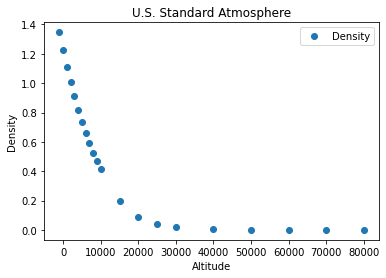

In [3]:
# plot the data

df.plot('Altitude','Density',style='o')
plt.ylabel('Density')
plt.title('U.S. Standard Atmosphere')
plt.show()

Observations:

Density vs. Altitude is obviously highly non-linear!

The suggested model to be used is $\rho = Ae^{Ba + C\sqrt{a}}$, where a is the altitude.

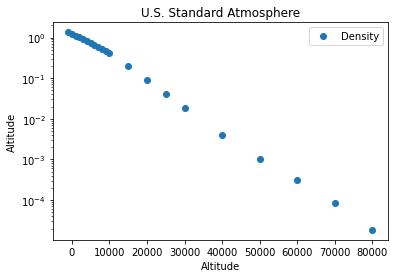

In [4]:
# Plot the data using a log scale on the y-axis

df.plot('Altitude','Density',style='o')
plt.yscale("log")
plt.ylabel('Altitude')
plt.title('U.S. Standard Atmosphere')
plt.show()

In [5]:
# define the fitting function

def myfitfunction(x,*paramlist):
    return paramlist[0]*np.exp(paramlist[1]*x+paramlist[2]*np.sqrt(x))

In [6]:
# use the curve_fit method from scipy.optimize to fit the data

from scipy.optimize import curve_fit

# make some guesses for the parameters A,B, and C as starting points.
init_vals = [1.0,-0.001,-0.00001]

# Set up the x and y arrays for the fit.  Ignore the first data point,
# which has a negative value for altitude, and thus will cause an error
# when we try to take the sqrt(a).

x = np.array(df['Altitude'][1:])
y = np.array(df['Density'][1:])

# Fit the data.  popt will contain the fit parameters, and pcov
# will contain the covariance matrix.

popt, pcov = curve_fit(myfitfunction,x,y,p0=init_vals)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


Coefficients (from curve_fit)
[ 1.21024743e+00 -1.30612869e-04  2.06342462e-03]
Covariance Matrix (from curve_fit)
[[ 2.25465070e-04  4.02843210e-08 -5.78976937e-06]
 [ 4.02843210e-08  2.74560033e-11 -2.54238030e-09]
 [-5.78976937e-06 -2.54238030e-09  2.71712146e-07]]


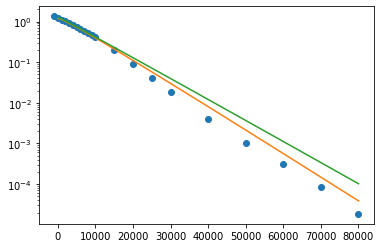

In [7]:
# Once we have the fit parameters, do a bit of bookkeeping
# in order to calculate the upper and lower confidence bounds of the fit

xi = np.linspace(0,80000,100)
ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([myfitfunction(xi,*pi) for pi in ps])
lower = np.percentile(ysample,5,axis=0)
upper = np.percentile(ysample,95,axis=0)

print("Coefficients (from curve_fit)")
print (popt)
print("Covariance Matrix (from curve_fit)")
print (pcov)

plt.plot(df.Altitude,df.Density,'o')
plt.plot(xi,lower)
plt.plot(xi,upper)
plt.yscale("log")
plt.show()

### The uncertainties in the fit parameters are given by the square root of the diagonal elements of the covariance matrix.

#### The fit does "ok", but misses most of the data points above a = 15000 m!

#### Note that these are very small densities, and since we are plotting on a log scale, the differences are highly accentuated.



In [8]:
print ("A = %0.3f +/- %0.3f" % (popt[0],np.sqrt(pcov[0][0])))
print ("B = %0.7f +/- %0.7f" % (popt[1],np.sqrt(pcov[1][1])))
print ("C = %0.5f +/- %0.5f" % (popt[2],np.sqrt(pcov[2][2])))

A = 1.210 +/- 0.015
B = -0.0001306 +/- 0.0000052
C = 0.00206 +/- 0.00052


In [9]:
# Add a column to the dataframe which is the log of the density
logrho = np.log(df['Density'])
df['LogDensity'] = logrho

df.head(100)

,Altitude,Temperature,Gravity,Pressure,Density,Viscosity,LogDensity
0,-1000,21.50,9.810,11.390000,1.347000,1.821,0.297880
1,0,15.00,9.807,10.130000,1.225000,1.789,0.202941
2,1000,8.50,9.804,8.988000,1.112000,1.758,0.106160
3,2000,2.00,9.801,7.950000,1.007000,1.726,0.006976
4,3000,-4.49,9.797,7.012000,0.909300,1.694,-0.095080
5,4000,-10.98,9.794,6.166000,0.819400,1.661,-0.199183
6,5000,-17.47,9.791,5.405000,0.736400,1.628,-0.305982
7,6000,-23.96,9.788,4.722000,0.660100,1.595,-0.415364
8,7000,-30.45,9.785,4.111000,0.590000,1.561,-0.527633
9,8000,-36.94,9.782,3.565000,0.525800,1.527,-0.642834


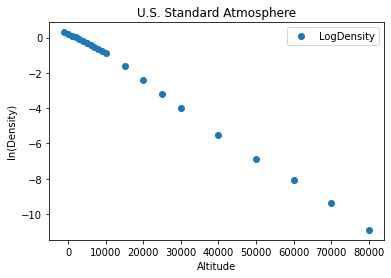

In [10]:
# plot the data

df.plot('Altitude','LogDensity',style='o')
plt.ylabel('ln(Density)')
plt.title('U.S. Standard Atmosphere')
plt.show()

In [11]:
# define the fitting function

def myfitfunctionlog(x,*paramlist):
    return paramlist[1]*x+paramlist[2]*np.sqrt(x)+np.log(paramlist[0])

In [12]:
# make some guesses for the parameters B and C as starting points.
init_vals = [1.0,-0.001,-0.00001]

# Set up the x and y arrays for the fit.  Ignore the first data point,
# which has a negative value for altitude, and thus will cause an error
# when we try to take the sqrt(a).

x = np.array(df['Altitude'][1:])
y = np.array(df['LogDensity'][1:])

# Fit the data.  popt will contain the fit parameters, and pcov
# will contain the covariance matrix.

popt, pcov = curve_fit(myfitfunctionlog,x,y,p0=init_vals)

Coefficients (from curve_fit)
[ 1.34831889e+00 -1.45638916e-04  1.29598412e-03]
Covariance Matrix (from curve_fit)
[[ 1.28529679e-02  4.10202204e-07 -1.40070064e-04]
 [ 4.10202204e-07  2.06821276e-11 -6.06265972e-09]
 [-1.40070064e-04 -6.06265972e-09  1.89379697e-06]]


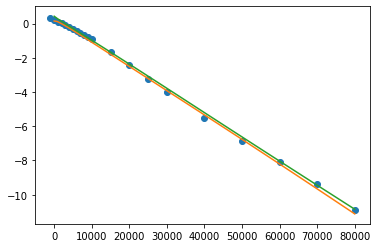

In [13]:
# Once we have the fit parameters, do a bit of bookkeeping
# in order to calculate the upper and lower confidence bounds of the fit

xi = np.linspace(0,80000,100)
ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([myfitfunctionlog(xi,*pi) for pi in ps])
lower = np.percentile(ysample,5,axis=0)
upper = np.percentile(ysample,95,axis=0)

print("Coefficients (from curve_fit)")
print (popt)
print("Covariance Matrix (from curve_fit)")
print (pcov)

plt.plot(df.Altitude,df.LogDensity,'o')
plt.plot(xi,lower)
plt.plot(xi,upper)
plt.show()

In [14]:
print ("A = %0.2f +/- %0.2f" % (popt[0],np.sqrt(pcov[0][0])))
print ("B = %0.7f +/- %0.7f" % (popt[1],np.sqrt(pcov[1][1])))
print ("C = %0.4f +/- %0.4f" % (popt[2],np.sqrt(pcov[2][2])))

A = 1.35 +/- 0.11
B = -0.0001456 +/- 0.0000045
C = 0.0013 +/- 0.0014


In [16]:
# Add a column to the dataframe which is a percentage uncertainty in the density.
drho = 0.01*df['Density']
df['DeltaRho'] = drho

df.head(100)

,Altitude,Temperature,Gravity,Pressure,Density,Viscosity,LogDensity,DeltaRho
0,-1000,21.50,9.810,11.390000,1.347000,1.821,0.297880,1.347000e-02
1,0,15.00,9.807,10.130000,1.225000,1.789,0.202941,1.225000e-02
2,1000,8.50,9.804,8.988000,1.112000,1.758,0.106160,1.112000e-02
3,2000,2.00,9.801,7.950000,1.007000,1.726,0.006976,1.007000e-02
4,3000,-4.49,9.797,7.012000,0.909300,1.694,-0.095080,9.093000e-03
5,4000,-10.98,9.794,6.166000,0.819400,1.661,-0.199183,8.194000e-03
6,5000,-17.47,9.791,5.405000,0.736400,1.628,-0.305982,7.364000e-03
7,6000,-23.96,9.788,4.722000,0.660100,1.595,-0.415364,6.601000e-03
8,7000,-30.45,9.785,4.111000,0.590000,1.561,-0.527633,5.900000e-03
9,8000,-36.94,9.782,3.565000,0.525800,1.527,-0.642834,5.258000e-03


<ErrorbarContainer object of 3 artists>

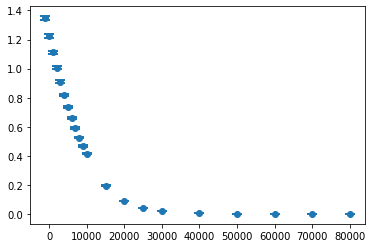

In [18]:
plt.errorbar(df.Altitude,df.Density,yerr=df.DeltaRho, fmt='o', capsize=5, capthick=2)

In [19]:
# use the curve_fit method from scipy.optimize to fit the data

from scipy.optimize import curve_fit

# make some guesses for the parameters A,B, and C as starting points.
init_vals = [1.0,-0.001,-0.00001]

# Set up the x and y arrays for the fit.  Ignore the first data point,
# which has a negative value for altitude, and thus will cause an error
# when we try to take the sqrt(a).

x = np.array(df['Altitude'][1:])
y = np.array(df['Density'][1:])
dy = np.array(df['DeltaRho'][1:])

# Fit the data.  popt will contain the fit parameters, and pcov
# will contain the covariance matrix.

popt, pcov = curve_fit(myfitfunction,x,y,p0=init_vals,sigma=dy)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


Coefficients (from curve_fit)
[ 1.34823582e+00 -1.45359848e-04  1.09103249e-03]
Covariance Matrix (from curve_fit)
[[ 1.17528946e-02  3.87675112e-07 -1.29251713e-04]
 [ 3.87675112e-07  2.21639961e-11 -6.19181288e-09]
 [-1.29251713e-04 -6.19181288e-09  1.85352868e-06]]


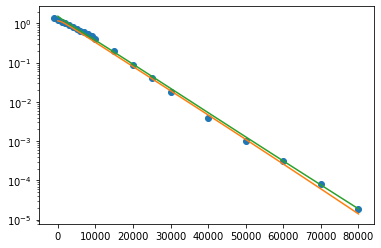

In [20]:
# Once we have the fit parameters, do a bit of bookkeeping
# in order to calculate the upper and lower confidence bounds of the fit

xi = np.linspace(0,80000,100)
ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([myfitfunction(xi,*pi) for pi in ps])
lower = np.percentile(ysample,5,axis=0)
upper = np.percentile(ysample,95,axis=0)

print("Coefficients (from curve_fit)")
print (popt)
print("Covariance Matrix (from curve_fit)")
print (pcov)

plt.plot(df.Altitude,df.Density,'o')
plt.plot(xi,lower)
plt.plot(xi,upper)
plt.yscale("log")
plt.show()

In [21]:
print ("A = %0.2f +/- %0.2f" % (popt[0],np.sqrt(pcov[0][0])))
print ("B = %0.7f +/- %0.7f" % (popt[1],np.sqrt(pcov[1][1])))
print ("C = %0.4f +/- %0.4f" % (popt[2],np.sqrt(pcov[2][2])))

A = 1.35 +/- 0.11
B = -0.0001454 +/- 0.0000047
C = 0.0011 +/- 0.0014
